In [1]:
%matplotlib inline

from random import random
from sklearn.utils import resample
from numpy import  zeros, ones, asarray
from numpy import load
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
from tensorflow_addons.layers import InstanceNormalization
import matplotlib.pyplot as plt
import os


C:\Users\user\anaconda3\envs\dl\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
def load_images(path, size=(256,256)):
  data_list = []
  
  for filename in os.listdir(path):
    # target size: a size to resize our image
    pixels = load_img(os.path.join(path, filename), target_size=size)
    pixels = img_to_array(pixels)
    data_list.append(pixels)
  
  return asarray(data_list)

In [3]:
path = "./monet2photo"

dataA_all = load_images(os.path.join(path, "trainA"))
dataA = resample(dataA_all, replace=False, n_samples=500, random_state=42)
dataB_All = load_images(os.path.join(path, "trainB"))
dataB = resample(dataB_All, replace=False, n_samples=500, random_state=42)


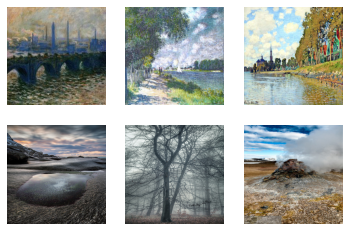

In [4]:
for i in range(3):
  plt.subplot(2, 3, 1+i)
  plt.axis("off")
  plt.imshow(dataA[i].astype("uint8"))
  
  plt.subplot(2, 3, 4+i)
  plt.axis("off")
  plt.imshow(dataB[i].astype("uint8"))

In [5]:
data = [dataA,dataB]
print(data[0].shape)

(500, 256, 256, 3)


In [6]:
def preprocess_data(data):
  X1, X2 = data[0], data[1]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1,X2]

In [7]:
dataset = preprocess_data(data)

In [8]:
def define_discriminator(image_shape):
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)
  d = Conv2D(64, (4,4), strides=2, padding="same", kernel_initializer=init)(in_image)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(128, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(256, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(512, (4,4), padding="same", kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  patch_out = Conv2D(1, (4,4), padding="same", kernel_initializer=init)(d)
  model = Model(in_image, patch_out)
  model.compile(loss="mse", optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
  return model

In [9]:
def resnet_block(n_filters, input_layer):
  init = RandomNormal(stddev=0.02)
  # as strides = 1, the shape is invariant
  g = Conv2D(n_filters, (3,3), padding="same", kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)
  g = Conv2D(n_filters, (3,3), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Concatenate()([g, input_layer])
  return g  


In [10]:
def define_generator(image_shape, n_resnet=9):
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)
  g = Conv2D(64, (7,7), padding="same", kernel_initializer=init)(in_image)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)
  
  g = Conv2D(128, (3,3), strides=(2,2), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)
  
  g = Conv2D(256, (3,3), strides=(2,2), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)
  
  for _ in range(n_resnet):
    g = resnet_block(256, g)
  
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)
  
  g = Conv2DTranspose(64, (3, 3), strides=(2,2), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  
  g = Conv2D(3, (7,7), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  out_image = Activation("tanh")(g)
  model = Model(in_image, out_image)
  
  return model

In [11]:
def define_composite_model(g_model_AB, d_model_B, g_model_BA, image_shape):
  g_model_AB.trainable = True
  d_model_B.trainable = False
  g_model_BA.trainable = False
  
  # adversarial loss
  input_gen = Input(shape=image_shape)
  g_AB = g_model_AB(input_gen)
  critic = d_model_B(g_AB)
  
  # identity loss
  input_B_id = Input(shape=image_shape)
  output_B_id = g_model_AB(input_B_id)
  
  # cycle loss - forward
  g_ABA_cycle = g_model_BA(g_AB)
  
  # cycle loss - backward
  gen_BA_out = g_model_BA(input_B_id)
  g_BAB_cycle = g_model_AB(gen_BA_out)

  # define model graph
  model = Model([input_gen, input_B_id], [critic, output_B_id, g_ABA_cycle, g_BAB_cycle])
  model.compile(loss=["mse", "mae", "mae", "mae"],
                loss_weights=[1, 5, 10, 10])
  return model

In [12]:
def load_real_sampels(filename):
  data = load(filename)
  X1, X2 = data["arr_0"], data["arr_1"]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]

In [13]:
def generate_real_samples(dataset, n_samples, patch_shape):
  indexes = randint(0, dataset.shape[0], n_samples)
  X = dataset[indexes]
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return X, y

In [14]:
def generate_fake_samples(g_model, dataset, patch_shape):
  X = g_model.predict(dataset)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [15]:
def save_models(step, g_model_AtoB, g_model_BtoA):
  # save the first generator model
  filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
  g_model_AtoB.save(filename1)
  # save the second generator model
  filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
  g_model_BtoA.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

In [16]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
  # select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
 
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
 
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
 
	# plot real images
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])
  
	# plot translated image
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])
  
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	plt.savefig(filename1)
	plt.close()


In [17]:
def update_image_pool(pool, images, max_size=50):
  selected = list()

  for image in images:
    if len(pool) < max_size:
      # stock the pool
      pool.append(image)
      selected.append(image)
    elif random() < 0.5:
      # use image, but don't add it to the pool
      selected.append(image)
    else:
      # replace an existing image and use replaced image
      index = randint(0, len(pool))
      selected.append(pool[index])
      pool[index] = image
  return asarray(selected)

In [21]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
  # define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
 
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
 
	# unpack dataset
	trainA, trainB = dataset
 
	# prepare image pool for fake images
	poolA, poolB = list(), list()
 
	# calculate the number of batches per training epoch
	batch_per_epo = int(len(trainA) / n_batch)
 
	# calculate the number of training iterations
	n_steps = batch_per_epo * n_epochs
    
	# manually enumerate epochs
	for i in range(n_steps):
		print(f"Step: {i}")
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
  
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
  
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
        
		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
  
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		
        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
  
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		
      # summarize performance
      #Since our batch size =1, the number of iterations would be same as the size of our dataset.
      #In one epoch you'd have iterations equal to the number of images.
      #If you have 100 images then 1 epoch would be 100 iterations
      
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance periodically
    #If batch size (total images)=100, performance will be summarized after every 75th iteration.
        
		if (i+1) % (batch_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (batch_per_epo * 5) == 0:
			# save the models
            # #If batch size (total images)=100, model will be saved after 
            #every 75th iteration x 5 = 375 iterations.
			save_models(i, g_model_AtoB, g_model_BtoA)

In [22]:
image_shape = dataset[0].shape[1:]
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)

composite_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
composite_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [23]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, composite_model_AtoB, composite_model_BtoA, dataset, epochs=5)

Step: 0
Iteration>1, dA[1.061,0.860] dB[1.189,0.665] g[16.623,17.258]
Step: 1


In [ ]:
import numpy as np

def show_plot(imagesX, imagesY1, imagesY2):
	images = np.vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images= (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		plt.subplot(1, len(images), 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(images[i])
		# title
		plt.title(titles[i])
		plt.show()
